In [1]:
import numpy as np 
import re
from scipy.interpolate import CubicSpline
from astropy.table import Table
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import c
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
#Read all the files from the SED modeling. 
folder = "../../SED_Modeling"

#Band information
bands = Table.read("{}/bandmag.dat".format(folder), format='ascii')
for i, hn in enumerate(['bname', 'bcal', 'jyzero']):
    bands.rename_column("col{}".format(i+1), hn)
bands['bname'][-2] = "g_misc"
bands['bname'][-1] = "r_misc"

#SED model parameters
d20 = Table.read("{}/double.20".format(folder), format='ascii')
for i, hn in enumerate(['i', 'redshift', 'chi2', 'vec1', 'vec2', 'vec3', 'vec4', 'vec5']):
    d20.rename_column("col{}".format(i+1), hn)
d22 = Table.read("{}/double.22".format(folder), format='ascii')
for i, hn in enumerate(['i', 'ebv1', 'ebv2', 'igm', 'wid']):
    d22.rename_column("col{}".format(i+1), hn)

#The Pran probs
pran = dict()
cat = open("{}/f_stat/comp.sort".format(folder))
for line in cat:
    x = line.split()
    pran[x[0]] = float(x[-1])

In [4]:
#Get the errors. 
mc_d20 = Table.read("{}/MC/double.20".format(folder), format='ascii')
for i, hn in enumerate(['i', 'redshift', 'chi2', 'vec1', 'vec2', 'vec3', 'vec4', 'vec5']):
    mc_d20.rename_column("col{}".format(i+1), hn)

mc_d22 = Table.read("{}/MC/double.22".format(folder), format='ascii')
for i, hn in enumerate(['i', 'ebv1', 'ebv2', 'igm']):
    mc_d22.rename_column("col{}".format(i+1), hn)

nrep = int(len(mc_d20)/len(d20))
probs = np.array([68.3, 95.4, 99.7])
intervals = np.concatenate([50-probs/2., 50+probs/2.])
for col in ['vec1', 'vec5']:
    for j in range(3):
        d20[col+'_l{}'.format(j+1)] = 0.
        d20[col+'_u{}'.format(j+1)] = 0.
    for i in range(len(d20)):
        aux = np.percentile(mc_d20[col][i*nrep:(i+1)*nrep], intervals)
        for j in range(3):
            d20[col+'_l{}'.format(j+1)][i] = d20[col][i] - aux[j]
            d20[col+'_u{}'.format(j+1)][i] = aux[j+3] - d20[col][i]

for col in ['ebv1', 'ebv2']:
    for j in range(3):
        d22[col+'_l{}'.format(j+1)] = 0.
        d22[col+'_u{}'.format(j+1)] = 0.
    for i in range(len(d22)):
        aux = np.percentile(mc_d22[col][i*nrep:(i+1)*nrep], intervals)
        for j in range(3):
            d22[col+'_l{}'.format(j+1)][i] = d22[col][i] - aux[j]
            d22[col+'_u{}'.format(j+1)][i] = aux[j+3] - d22[col][i]


# for col in ['evec1_u', 'evec1_l', 'evec5_u', 'evec5_l']:
#     d20[col] = 0.0
# for col in ['ebv1_u', 'ebv1_l', 'ebv2_u', 'ebv2_l']:
#     d22[col] = 0.0

# nrep = int(len(mc_d20)/len(d20))
# print(nrep)
# for i in range(len(d20)):
#     d20['evec1_u'][i] = np.percentile(mc_d20['vec1'][i*nrep:(i+1)*nrep], 50.+68.3/2)
#     d20['evec1_l'][i] = np.percentile(mc_d20['vec1'][i*nrep:(i+1)*nrep], 50.-68.3/2)
#     d20['evec5_u'][i] = np.percentile(mc_d20['vec5'][i*nrep:(i+1)*nrep], 50.+68.3/2)
#     d20['evec5_l'][i] = np.percentile(mc_d20['vec5'][i*nrep:(i+1)*nrep], 50.-68.3/2)
#     d22['ebv1_u'][i]  = np.percentile(mc_d22['ebv1'][i*nrep:(i+1)*nrep], 50.+68.3/2)
#     d22['ebv1_l'][i]  = np.percentile(mc_d22['ebv1'][i*nrep:(i+1)*nrep], 50.-68.3/2)
#     d22['ebv2_u'][i]  = np.percentile(mc_d22['ebv2'][i*nrep:(i+1)*nrep], 50.+68.3/2)
#     d22['ebv2_l'][i]  = np.percentile(mc_d22['ebv2'][i*nrep:(i+1)*nrep], 50.-68.3/2)

# d20['evec1_u'] = d20['evec1_u'] - d20['vec1']
# d20['evec1_l'] = d20['vec1'] - d20['evec1_l']
# d20['evec5_u'] = d20['evec5_u'] - d20['vec5']
# d20['evec5_l'] = d20['vec5'] - d20['evec5_l']
# d22['ebv1_u']  = d22['ebv1_u'] - d22['ebv1']
# d22['ebv1_l']  = d22['ebv1'] - d22['ebv1_l']
# d22['ebv2_u']  = d22['ebv2_u'] - d22['ebv2']
# d22['ebv2_l']  = d22['ebv2'] - d22['ebv2_l']


In [5]:
d22.show_in_notebook()

idx,i,ebv1,ebv2,igm,wid,ebv1_l1,ebv1_u1,ebv1_l2,ebv1_u2,ebv1_l3,ebv1_u3,ebv2_l1,ebv2_u1,ebv2_l2,ebv2_u2,ebv2_l3,ebv2_u3
0,1,5.011872,0.03162278,1.4,W0019-1046,0.17481897550000003,0.3859552284999994,0.5645996330000003,0.6798098489999997,1.0308000000000002,1.1205602204999972,0.03162278,0.04781004,0.03162278,0.06837722,0.03162278,0.06837722
1,2,4.323613,0.0,0.4451524,W0116-0505,0.8971678034999999,1.3336057595000002,1.481822868,3.621427833000002,1.8117269999999999,5.676387,0.0,0.0,0.0,0.01258925,0.0,0.025312945514999987
2,3,10.0,0.1,0.0,W0204-0506,2.5524693459999996,0.9504600649999997,3.6904269999999997,3.0247805700000026,3.830915861000001,5.182598579999999,0.08004738,0.0,0.1,0.0,0.1,0.0
3,4,7.570073,0.0,0.3727581,W0220+0137,1.1282074739999999,0.8158223910000002,1.5841577650000014,1.7900650150000006,2.5582009999999995,2.441922879999999,0.0,0.0,0.0,0.00023000000000024558,0.0,0.014223979519999885
4,5,3.162278,0.01584893,1.4,W0831+0140,0.0,0.4685333974999999,0.4129325890000004,0.818794,0.6503920000000001,1.2633451869999948,0.01584893,0.015773850000000002,0.01584893,0.034269789999999994,0.01584893,0.047246800000000005


In [6]:
#Read the photometry
d21_raw = np.loadtxt("{}/double.21".format(folder))
nchan = len(bands)
d21 = Table()
d21['wid'] = d22['wid']
for k, bname in enumerate(bands['bname']):
    d21[bname] = d21_raw[k::nchan, 1] * u.Jy
    d21[bname+" mod"] = d21_raw[k::nchan, 2] * u.Jy
    d21[bname+" err"] = d21_raw[k::nchan, 3] * u.Jy

In [7]:
dbase = Table.read("{}/dbase.fits".format(folder))
coords = dict()
for wid in pran.keys():
    k = np.where(dbase['Short Name']==wid)[0][0]
    coords[wid] = SkyCoord(ra=dbase['ra'][k]*u.deg, dec=dbase['dec'][k]*u.deg)

In [8]:
coords['W0116-0505'].to_string(style='hmsdms', sep=":")

'01:16:01.411584 -05:05:04.09308'

In [9]:
#We now want to get the 6um luminosities of the unreddened best-fit quasar templates. 
seds = np.loadtxt("{}/agn_spec.dat".format(folder), skiprows=1)
agn_sed = CubicSpline(seds[:,0], seds[:,2])

In [10]:
# #Calculate the 6um luminosities for each target. 
# z = d20['redshift']
# DL = cosmo.luminosity_distance(z)
# for j, vec in enumerate(['vec1', 'vec5']):
#     f_nu = d20[vec]*agn_sed(6.0) * u.Jy
#     L_nu = (4.*np.pi*DL**2)/(1+z) * f_nu
#     L6um = (c/(6*u.micron) * L_nu).to(u.erg/u.s)
#     d22['log L6um AGN{}'.format(j+1)] = np.log10(L6um.value)

In [19]:
d20.show_in_notebook()

idx,i,redshift,chi2,vec1,vec2,vec3,vec4,vec5,vec1_l1,vec1_u1,vec1_l2,vec1_u2,vec1_l3,vec1_u3,vec5_l1,vec5_u1,vec5_l2,vec5_u2,vec5_l3,vec5_u3
0,1,1.641,5.081521,0.002470636,7.007495e-06,0.0,3.758273e-06,2.793912e-05,0.00015378803550000026,0.0001944293815000003,0.00035321141900000004,0.000398423801,0.000523776814000001,0.0005066907734999986,7.633538515e-06,1.9403237900000003e-05,1.436679121e-05,3.6533970390000014e-05,1.807547717700002e-05,4.8462069379999966e-05
1,2,3.173,24.02249,0.004411795,3.869816e-05,0.0,0.0,3.837841e-05,0.0007490992329999995,0.0012021650480000005,0.0013007312939999995,0.0034083601850000006,0.0016182150595,0.005257226660499997,4.8986442750000015e-06,1.7974016250000045e-06,1.2959254180000011e-05,6.892268940000005e-06,2.2189424490000005e-05,1.549276497999998e-05
2,3,2.099307,17.83592,0.003593931,0.0,2.776747e-05,0.0,4.697634e-05,0.0007605498495,0.0003742709889999994,0.001104121765,0.0010518939580000004,0.0013212229520000013,0.001917035733499997,3.1895415295e-05,5.436938725000002e-06,4.176917493900001e-05,1.2471016240000003e-05,4.697634e-05,2.1336973839999947e-05
3,4,3.122,6.049306,0.005571716,1.533589e-05,8.421436e-07,0.0,2.792184e-05,0.0007908629340000004,0.0006765957935000004,0.001265523250000001,0.0015236620950000003,0.0018943105635000016,0.002540494962999999,1.3616681950000016e-06,7.750158050000007e-07,2.963608320000003e-06,2.5360237200000013e-06,5.411297100000004e-06,5.441989005000001e-06
4,5,3.888,5.716598,0.005847326,1.819741e-05,0.0,1.039276e-05,3.070182e-05,0.00027461929599999994,0.0005696274595000002,0.0006392416840000003,0.0012091261,0.0010285514005000012,0.0016856274529999972,8.446900555e-06,1.667144612e-05,1.4326801799999999e-05,3.2621943179999995e-05,1.8536166935e-05,5.6868019139999866e-05


In [11]:
#Calculate the 6um luminosities for each target. 
z = d20['redshift']
DL = cosmo.luminosity_distance(z)
for j, vec in enumerate(['vec1', 'vec5']):
    f_nu = d20[vec]*agn_sed(6.0) * u.Jy
    L_nu = (4.*np.pi*DL**2)/(1+z) * f_nu
    L6um = (c/(6*u.micron) * L_nu).to(u.erg/u.s)
    d22['log L6um AGN{}'.format(j+1)] = np.log10(L6um.value)
    for k in range(3):
        d22['log L6um AGN{}_l{}'.format(j+1,k+1)] = np.log10(L6um.value) - np.log10(L6um.value * (d20[vec]-d20[vec+"_l{}".format(k+1)])/d20[vec])
        d22['log L6um AGN{}_u{}'.format(j+1,k+1)] = np.log10(L6um.value * (d20[vec]+d20[vec+"_u{}".format(k+1)])/d20[vec]) - np.log10(L6um.value)

/var/folders/p7/drxzchtj4yb641v79lt0tjyh0000gn/T/ipykernel_82912/4061056990.py:10: RuntimeWarning: divide by zero encountered in log10
  d22['log L6um AGN{}_l{}'.format(j+1,k+1)] = np.log10(L6um.value) - np.log10(L6um.value * (d20[vec]-d20[vec+"_l{}".format(k+1)])/d20[vec])


In [20]:
d22.show_in_notebook()

idx,i,ebv1,ebv2,igm,wid,ebv1_l1,ebv1_u1,ebv1_l2,ebv1_u2,ebv1_l3,ebv1_u3,ebv2_l1,ebv2_u1,ebv2_l2,ebv2_u2,ebv2_l3,ebv2_u3,log L6um AGN1,log L6um AGN1_l1,log L6um AGN1_u1,log L6um AGN1_l2,log L6um AGN1_u2,log L6um AGN1_l3,log L6um AGN1_u3,log L6um AGN2,log L6um AGN2_l1,log L6um AGN2_u1,log L6um AGN2_l2,log L6um AGN2_u2,log L6um AGN2_l3,log L6um AGN2_u3
0,1,5.011872,0.03162278,1.4,W0019-1046,0.17481897550000003,0.3859552284999994,0.5645996330000003,0.6798098489999997,1.0308000000000002,1.1205602204999972,0.03162278,0.04781004,0.03162278,0.06837722,0.03162278,0.06837722,46.52965748823731,0.027911229715243735,0.03289910265189633,0.06700081483825215,0.06493083522138932,0.10347422464371903,0.08101773751746322,44.58306144593525,0.1385972922281553,0.22903716129920326,0.313558351101328,0.3631657647601969,0.45217538556531167,0.43688739653676834
1,2,4.323613,0.0,0.4451524,W0116-0505,0.8971678034999999,1.3336057595000002,1.481822868,3.621427833000002,1.8117269999999999,5.676387,0.0,0.0,0.0,0.01258925,0.0,0.025312945514999987,47.27990372359331,0.08081447762084792,0.1046539934745141,0.15170641980627408,0.24860004722864915,0.19845422060445372,0.34076720897905943,45.21937537758478,0.059304567798285746,0.019877680918099827,0.17892585478040246,0.07173002965826214,0.37486734380151177,0.14726946986225897
2,3,10.0,0.1,0.0,W0204-0506,2.5524693459999996,0.9504600649999997,3.6904269999999997,3.0247805700000026,3.830915861000001,5.182598579999999,0.08004738,0.0,0.1,0.0,0.1,0.0,46.88544124143789,0.1032647344514146,0.04302403563790591,0.1594036613619494,0.11149310792324485,0.19902608496552432,0.18565805463136797,45.001750683817434,0.49345120556080246,0.047562150747566534,0.9552778326809346,0.10225336811607377,inf,0.1626261760256753
3,4,7.570073,0.0,0.3727581,W0220+0137,1.1282074739999999,0.8158223910000002,1.5841577650000014,1.7900650150000006,2.5582009999999995,2.441922879999999,0.0,0.0,0.0,0.00023000000000024558,0.0,0.014223979519999885,47.369722419587696,0.06648357521395099,0.04977372131988034,0.11189550614637511,0.10498657130446531,0.18044745779890548,0.1631502646540426,45.06967748214678,0.02171315418680564,0.011890281368181377,0.048730222307618476,0.037755405011694165,0.09355806487214835,0.07733185256503816
4,5,3.162278,0.01584893,1.4,W0831+0140,0.0,0.4685333974999999,0.4129325890000004,0.818794,0.6503920000000001,1.2633451869999948,0.01584893,0.015773850000000002,0.01584893,0.034269789999999994,0.01584893,0.047246800000000005,47.5443374862671,0.020891120896777693,0.040371582187944455,0.05027930068524,0.08162909054943412,0.0840206948463802,0.11000797659513495,45.264544300139896,0.13973809453442243,0.18836920675757796,0.27298232980184167,0.3144025948788425,0.40202869388684803,0.45519043077602106


(array([127.,   0.,   0.,   0.,   0.,  10.,  10.,  10.,   0.,  12.,   1.,
          1.,  11.,   0.,   2.,  20.,   1.,   1.,   0.,  25.,   2.,   0.,
          0.,   1.,   0.,  36.,   0.,   1.,   0.,   2.,   0.,  43.,   1.,
          0.,   1.,   1.,   0.,   0.,   0.,  76.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 605.]),
 array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
        0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
        0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
        0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
        0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  ]),
 <BarContainer object of 50 artists>)

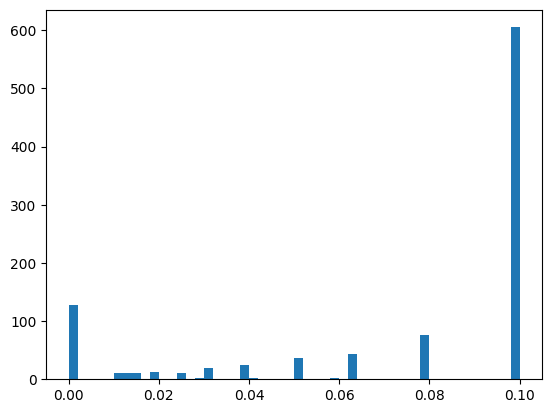

In [21]:
plt.hist(mc_d22['ebv2'][2*nrep:3*nrep], bins=50)

In [17]:
#Final table.
wids = ['W0019$-$1046', 'W0116$-$0505', 'W0204$-$0506', 'W0220+0137', 'W0831+0140']
k = list()
for wid in wids:
    k.append(np.argwhere(d22['wid']==re.sub("\$","",wid))[0][0])

Ftab = Table()
Ftab['Short WISE ID'] = wids

ra  = [None]*len(wids)
dec = [None]*len(wids)
for i, wid in enumerate(wids):
    hmsdms1 = coords[re.sub("\$","",wid)].to_string(style='hmsdms', sep=':', precision=1)
    hmsdms2 = coords[re.sub("\$","",wid)].to_string(style='hmsdms', sep=':', precision=2)
    ra[i]  = hmsdms2.split()[0]
    dec[i] = re.sub("-","$-$",hmsdms1.split()[1])
Ftab['R.A.'] = ra
Ftab['Dec.'] = dec

Ftab['Redshift'] = d20['redshift'][k]
Ftab['Redshift'].info.format = '7.3f'

#Ftab['rmag'] = -2.5*np.log10(d21['sdssr'][k]/(3631.*u.Jy))
#Ftab['rmag'].info.format = '5.2f'

# Ftab['log L6um AGN1'] = d22['log L6um AGN1'][k]
# Ftab['log L6um AGN1'].info.format = '5.2f'

# Ftab['E(B-V) AGN1'] = d22['ebv1'][k] 
# Ftab['E(B-V) AGN1'].info.format = '5.2f'

# Ftab['log L6um AGN2'] = d22['log L6um AGN2'][k]
# Ftab['log L6um AGN2'].info.format = '5.2f'

# Ftab['E(B-V) AGN2'] = d22['ebv2'][k] 
# Ftab['E(B-V) AGN2'].info.format = '5.2f'


for cols in [('log L6um AGN1', 'log L6um AGN1'), ('E(B-V) AGN1', 'ebv1'), ('log L6um AGN2','log L6um AGN2'), ('E(B-V) AGN2','ebv2')]:
    col1, col2 = cols
    Ftab[col1] = "{:28s}".format(" ")
    for i in range(len(d22)):
        Ftab[col1][i] = "${:5.3f}^{{+{:5.3f}}}_{{-{:5.3f}}}$".format(d22[col2][i], d22[col2+"_u1"][i], d22[col+"_l1"][i])

Ftab['p_ran'] = np.zeros(len(wids))
for i, wid in enumerate(wids):
    Ftab['p_ran'][i] = pran[re.sub("\$","",wid)]*1e2
Ftab['p_ran'].info.format = '5.3f'


In [18]:
Ftab.write("targets.tex", format='latex', overwrite=True)